In [ ]:
!pip install legwork
!pip install wget
!pip install astropy
!pip install tqdm

We'll use data from [Thiele+2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...945..162T/abstract) that was created by COSMIC. The data we'll use is from the `alpha25` model which sets `α=0.25`; this means that the common envelope ejection efficiency is very low and many binaries merge while the stars are interacting. This gives us a quick/easy way to access the data that doesn't take a ton of time to download.

If you wanted a more optimistic population [read: more Galactic binaries], you could check out the `fiducial` (`α=1`) or `q3` (allows for larger mass ratios to get stable mass transfer) models.

We'll also use legwork to **create a "present day" Milky Way disk population** from the simulated double white dwarfs.

In [ ]:
import legwork as lw
import wget
import pandas as pd
import astropy.units as u
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Downloading data
wget.download("https://zenodo.org/records/7144944/files/alpha25_10_10_14.h5?download=1", out="HeHe_DWD.h5")
wget.download("https://zenodo.org/records/7144944/files/alpha25_11_10_14.h5?download=1", out="COHe_DWD.h5")
wget.download("https://zenodo.org/records/7144944/files/alpha25_11_11_14.h5?download=1", out="COCO_DWD.h5")
wget.download("https://zenodo.org/records/7144944/files/alpha25_12_10_12_14.h5?download=1", out="ONeX_DWD.h5")

'ONeX_DWD (1).h5'

You can see that we've downloaded all the data we need and saved it into files labeled by different double white dwarf types by using the `ls` feature in the terminal. Any terminal commands you want to apply in Colab can be done using the "!".


The four double white dwarf types are split into binaries containing helium white dwarfs (He), carbon oxygen white dwarfs (CO) or oxygen neon white dwarfs (ONe). In the case of ONe, these are pretty rare so we grab any of He, CO or ONe companions to ONe primaries.

In [ ]:
!ls

'COCO_DWD (1).h5'   COHe_DWD.h5		      HeHe_DWD.h5	 sample_data
 COCO_DWD.h5	    Galactic_foreground.png  'ONeX_DWD (1).h5'
'COHe_DWD (1).h5'  'HeHe_DWD (1).h5'	      ONeX_DWD.h5


These data sets contain one line per binary where the binary parameters like mass and period are given at the time of the formation of the second white darf. At this point, the only evolution that will happen to the binary is through the emission of gravitational waves -- **legwork handles that evolution!**

In order to make a population that is a realistic representation of the Milky Way Galactic disk, we will make a few **assumptions**:
- Stars formed in the disk have solar metallicity
- Stars formed in the disk have formed constantly over the last 10 Gyr
- Stars formed in the disk follow a double exponential disk model: exp(-r/r0)exp(-z/z0) with r0=2.6 kpc and z0=0.3 kpc
- The Galactic disk has 4.32e10 solar masses of stars
- The binary fraction of white dwarf progenitor stars is 0.5

In the cell below, we have written a few functions that apply these assumptions.

In [ ]:
def get_N_DWD_disk(N_DWD_sim, mass_stars, M_disk):
  # In the simulations, we assumed all stars are binaries; here we will normalize to
  # a binary fraction of 0.5
  mass_stars = (1 + 0.64) * mass_stars

  # the number of DWDs that form in the disk is the yield of DWDs per unit solar mass
  # multplied by the total mass in the disk:
  N_DWD_disk = int(N_DWD_sim / mass_stars * M_disk)

  return N_DWD_disk


def assign_ages_to_disk_DWDs(DWD_df, max_age=10000):
  ages = np.random.uniform(0, max_age, len(DWD_df))
  DWD_df['t_ZAMS'] = ages

  # the amount of time we should evolve each DWD to get to the present day is
  # then the ZAMS age minus the time to form the DWD itself through binary evolution
  DWD_df['t_evol_GW'] = DWD_df['t_ZAMS'].values - DWD_df['tphys'].values

  # We only want sources that will be DWDs at present, so remove anything with a negative
  # DWD_df.t_evol_GW < 0
  DWD_df = DWD_df.loc[DWD_df.t_evol_GW > 0].copy()

  return DWD_df


def sample_exponential_radial(size, scale_height):
    """Sample a collection of numbers of size=size distributed according
    to a radial exponential function with a user specific scale height

    Parameters
    ----------
    size : int
        Size of the sample
    scale_height : float
        Scale height of the distribution

    Returns
    -------
    distributed_nums : array
        Array of sampled values
    """

    rand_nums = np.random.uniform(0, 1, size)
    distributed_nums = -scale_height * np.log(1.0 - rand_nums)

    return distributed_nums

def sample_exponential_vertical(size, scale_height):
    """Sample a collection of numbers of size=size distributed according
    to a vertical exponential function with a user specific scale height

    Parameters
    ----------
    size : int
        Size of the sample
    scale_height : float
        Scale height of the distribution

    Returns
    -------
    distributed_nums : array
        Array of sampled values
    """

    rand_nums = np.random.uniform(0, 1, size)
    distributed_nums = -scale_height * np.log(1.0 - rand_nums)

    # Choose a position above or below the disk
    pos_neg_choose = np.random.uniform(0, 1, size)
    negInd, = np.where(pos_neg_choose < 0.5)
    distributed_nums[negInd] = distributed_nums[negInd] * (-1.0)

    return distributed_nums


def assign_positions_to_disk_DWDs(DWD_df, r0=2.3, z0=0.3):
  r = sample_exponential_radial(size=len(DWD_df), scale_height=2.9)
  z = sample_exponential_vertical(size=len(DWD_df), scale_height=0.3)

  # Assign the azimuthal positions:
  phi = np.random.uniform(0, 2*np.pi, size=len(DWD_df))

  # convert to cartesian:
  xGX = r * np.cos(phi)
  yGX = r * np.sin(phi)
  zGX = z

  DWD_df['xGx'] = xGX
  DWD_df['yGx'] = yGX
  DWD_df['zGx'] = zGX

  # assume that the Sun is positioned 8 kpc radially away and 25 pc above
  # the Galactic Center
  DWD_df['dist'] = ((xGX - 8)**2 + yGX**2 + (zGX - 0.025)**2)

  return DWD_df





In [ ]:
# Clear out a Galaxy file if you've already creaetd one
!rm Galactic_disk_DWDs.h5

rm: cannot remove 'Galactic_disk_DWDs.h5': No such file or directory


In [ ]:
from collections.abc import ValuesView
DWD_types = ['HeHe', 'COHe', 'COCO', 'ONeX']
dat_write = 'Galactic_disk_DWDs.h5'

DWD_LISA = []
for DWD_type in DWD_types:
  print(f'creating disk population for type: {DWD_type}')
  dat = pd.read_hdf(f'{DWD_type}_DWD.h5', key='conv')
  # cut to only have short period DWDs
  dat = dat.loc[dat.sep < 5000]
  mass_stars = pd.read_hdf(f'{DWD_type}_DWD.h5', key='mass_stars').max()[0]

  # Loop over the Galactic Disk creation for each DWD type to save on RAM
  n_loop = 200
  for ii in tqdm.tqdm(range(n_loop)):
    #Calculate the number of DWDs formed in the disk based on the COSMIC simulations
    N_DWD_disk = get_N_DWD_disk(N_DWD_sim=len(dat), mass_stars=mass_stars, M_disk=4.32e10/n_loop)

    #Sample with replacement from the simulations
    DWD_disk = dat.sample(n=N_DWD_disk, replace=True)

    #Assign ages uniformly over 10 Gyr (10,000 Myr)
    DWD_disk = assign_ages_to_disk_DWDs(DWD_df=DWD_disk, max_age=10000)

    #Evolve the DWDs from formation to present day:
    f_orb_final = lw.evol.evol_circ(t_evol=DWD_disk.t_evol_GW.values * u.Myr,
                                m_1=DWD_disk.mass_1.values * u.Msun,
                                m_2=DWD_disk.mass_1.values * u.Msun,
                                a_i=DWD_disk.sep.values * u.Rsun)
    # GW frequency is 2*f_orb
    DWD_disk['f_gw_final'] = 2*f_orb_final[:,-1].to(u.Hz).value

    #Cut on the LISA frequency range: f_gw_final > 1e-4 Hz
    DWD_disk = DWD_disk.loc[(DWD_disk.f_gw_final > 1e-4) & (DWD_disk.f_gw_final < 1e-1)].copy()

    #Assign positions for LISA sources
    DWD_disk = assign_positions_to_disk_DWDs(DWD_df=DWD_disk, r0=2.3, z0=0.3)

    #Calculate the gravitational wave power
    DWD_disk['h0'] = lw.strain.h_0_n(
      m_c=lw.utils.chirp_mass(
         m_1=DWD_disk.mass_1.values * u.Msun,
         m_2=DWD_disk.mass_1.values * u.Msun,
         ),
      f_orb=DWD_disk.f_gw_final.values/2 * u.Hz,
      ecc=np.zeros(len(DWD_disk)), #All DWDs formed by cosmic are circular
      n=2,
      dist=DWD_disk['dist'].values * u.kpc
    ).flatten()

    # save the data to the key based on the DWD type
    if len(DWD_LISA) == 0:
      DWD_LISA = DWD_disk
    else:
      DWD_LISA = pd.concat([DWD_LISA, DWD_disk])

    # clear the memory
    DWD_disk = []

  # clear the dat file memory too
  dat = []



creating disk population for type: HeHe


100%|██████████| 200/200 [00:09<00:00, 20.66it/s]


creating disk population for type: COHe


100%|██████████| 200/200 [00:39<00:00,  5.00it/s]


creating disk population for type: COCO


100%|██████████| 200/200 [01:42<00:00,  1.94it/s]


creating disk population for type: ONeX


100%|██████████| 200/200 [00:20<00:00,  9.99it/s]


Now that we have the double white dwarf population with frequencies in the LISA band, we can assign them to frequency bins according to the LISA frequency resolution. The frequency resolution in Hz is just the inverse of the observation duration in seconds. For now, let's assume that the observation duration is 4 years.

Next, we need to figure out which bins each binary will fall into -- luckily, this is pretty easily handled with `np.digitize` and the `groupby` function in pandas. By digitizing the frequencies of each binary into the LISA frequency bins, we can now add all up the total power spectral density for each frequency. This is saved in power_foreground.

In [ ]:
T_obs_duration = 4 * 3.155e7
LISA_frequency_bins = np.arange(1e-4, 1e-1, 1/T_obs_duration)
DWD_LISA['f_bins'] = np.digitize(DWD_LISA.f_gw_final.values, LISA_frequency_bins)
DWD_LISA['PSD'] = DWD_LISA.h0**2 * T_obs_duration
power = DWD_LISA.groupby('f_bins').PSD.sum()

power_foreground = np.zeros(len(LISA_frequency_bins)+1)
power_foreground[np.array(power.index.astype(int))] = power

Finally, we can plot the Galactic foreground using the LISA frequency bins and the foreground power spectral density, or PSD.


**How would you add a senstivity curve to this figure using legwork?**

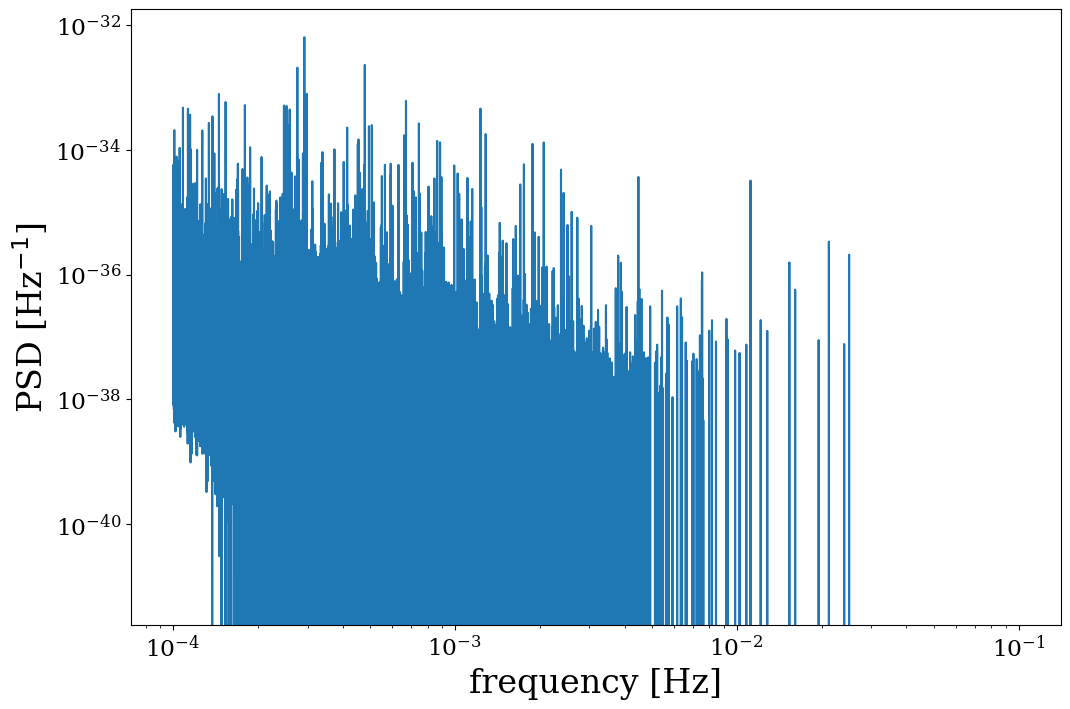

In [ ]:
plt.plot(LISA_frequency_bins, power_foreground[1:])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [Hz$^{-1}$]')

plt.savefig('Galactic_foreground.png')
